## Training and Validation set



**What Is a Validation Set**
we usually split our dataset into **three parts**:

1. **Training set** – used to **train** the model.
2. **Validation set** – used to **tune** the model.
3. **Test set** – used to **evaluate** the model after everything is done.

---

**Purpose of the Validation Set**

The validation set helps us:

- **Monitor model performance during training.**
- **Tune hyperparameters** (e.g., learning rate, number of layers, regularization).
- **Detect overfitting** – when the model learns the training data too well and fails to generalize.
---


**How It Works**

Let’s say you’re training a model for 20 epochs.

- After each epoch (a full pass over the training data), the model’s accuracy/loss is also calculated on the **validation set**.
- If the **validation loss starts increasing** while training loss is decreasing, it means **overfitting** is happening.
- You can use this to **stop training early** or pick the best version of your model (called **early stopping**).




```python
dataset = datasets.MNIST(root=data_dir, train=True,download=True, transform=transform)
```

Split it to $80%$, $20%$


- If your dataset is small, you can use **k-fold cross-validation** instead of a fixed validation set.
- In deep learning, many people use an **80/10/10** or **70/15/15** split for training/validation/test.


```python
train_size = int(0.8*len(dataset))
validation_size = len(dataset)-train_size
train_set, val_set = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
```

Let's define **MNIST** simple example, input images are $28\times 28$, and sinc we have only digits, we have $10$ outputs:


In [11]:
import torch.nn as nn
import torch
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


To see the weight and biases:

In [9]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")


fc1.weight: torch.Size([128, 784])
fc1.bias: torch.Size([128])
fc2.weight: torch.Size([64, 128])
fc2.bias: torch.Size([64])
fc3.weight: torch.Size([10, 64])
fc3.bias: torch.Size([10])


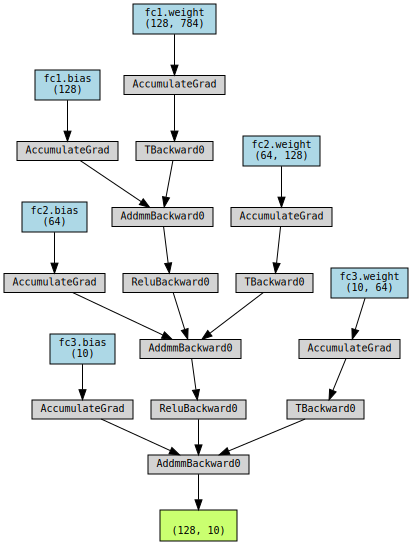

In [17]:
import torchviz
from IPython.display import display, SVG  # Import SVG display

model=SimpleNN()
input=torch.randn(size=[28*28, 128])

# dot=torchviz.make_dot(model(input),params=dict(model.named_parameters()),show_attrs=True, show_saved=True )
dot=torchviz.make_dot(model(input),params=dict(model.named_parameters()) )

# Render as SVG and display directly in the notebook
dot.format = 'svg'
svg_string = dot.pipe().decode('utf-8')  # Get the SVG string
display(SVG(svg_string))

And we pass the to optimizer:

```python
optimizer = optim.Adam(model.parameters(), lr=0.001)
```

These are the ones affected by `loss.backward()` and `optimizer.step()`.

### Test Set

```python
test_set = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)
```

```python
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)
```

```python
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy
```

### `autograd` and `torch.no_grad()`:
In PyTorch, **autograd (automatic differentiation)** is enabled by default. This means:
- Every operation is tracked in a **computational graph**
- Gradients can be calculated with `.backward()`

But during **evaluation** (validation or test), we don’t need to compute gradients. So:


- Temporarily **disables autograd**
- Reduces **memory usage**
- Speeds up **inference**
- Prevents unnecessary **graph building**

You should always use `with torch.no_grad():` during **validation** or **inference**

`correct += (outputs.argmax(1) == labels).sum().item()` 

Let’s break this line into pieces.

Assume:
```python
outputs.shape = (64, 10)  # 64 samples, 10 class scores per sample
labels.shape = (64,)      # true class labels (0 to 9)
```

- `outputs.argmax(1)` → returns the **predicted class index** per sample
  - Shape: `[64]`
- `== labels` → element-wise comparison: True if prediction is correct
  - Shape: `[64]` of `True/False`
- `.sum()` → counts how many predictions are correct
- `.item()` → converts the single scalar tensor to a Python `int`
- `correct += ...` → accumulate total correct predictions across all batches

### 🔍 Full Example:
```python
# Suppose predictions are [2, 1, 0, 3]
# and true labels are  [2, 0, 0, 3]
# Comparison: [T, F, T, T] → sum = 3
```


## What Is Stored in `loss`?

Let’s say you have:

```python
criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, labels)
```

- `outputs` shape: `[batch_size, num_classes]`
- `labels` shape: `[batch_size]` (class indices)


`CrossEntropyLoss` combines:
1. **`LogSoftmax`** over output logits
2. **Negative log-likelihood**

So it computes:
$ \text{loss} = -\frac{1}{N} \sum_{i=1}^{N} \log \left( \text{softmax}(x_i)_{y_i} \right) $

**What’s inside `loss`**?
- A **scalar tensor** (e.g., `tensor(1.8634, grad_fn=<NllLossBackward>)`)
- It represents the **average loss** over the batch
- It tracks the **gradient graph**, so calling `.backward()` will compute gradients

To inspect:
```python
print(loss)
print(loss.item())  # to get float
```

If you want **individual per-sample losses**:
```python
criterion = nn.CrossEntropyLoss(reduction='none')
losses = criterion(outputs, labels)  # tensor of shape [batch_size]
```

---

loss: it is sum of `CrossEntropyLoss`  over all outputs and labels (we calculate it for all batches and make an average over the batch size)
```
loss:  tensor(2.3085, device='cuda:0', grad_fn=<NllLossBackward0>)
```

---

loss.item()
```
loss.item():  2.3084824085235596
```

---


```
outputs.shape:  torch.Size([64, 10])
```

---

```
outputs:  tensor([[-0.0878,  0.0970,  0.0720,  0.1041, -0.0197, -0.0194, -0.0781, -0.0617,0.0722, -0.0009],
                 [...],
                 [-0.0541,  0.0800,  0.0789,  0.0715,  0.0250, -0.0123, -0.0937, -0.0662, 0.1120,  0.0342]],
device='cuda:0', grad_fn=<AddmmBackward0>)
```
---


outputs.argmax(1): we have $64$ batches (output is $64 \times 10$), it finds the max in each row, so we have 64 values here, since we are classifying numbers between $0$ to $9$ each max value point exactly to the same class of digit, so we can just compare them with labels to check if the output of network is correct:

```
outputs.argmax(1):  tensor([3, 8, 2, 8, 8, 8, 8, 8, 1, 1, 2, 8, 8, 8, 8, 8, 8, 2, 8, 1, 3, 1, 3, 2,
        2, 8, 8, 8, 2, 2, 8, 1, 8, 8, 2, 2, 8, 8, 3, 2, 1, 8, 3, 8, 2, 8, 3, 3,
        8, 2, 1, 8, 3, 1, 8, 8, 3, 8, 8, 1, 2, 8, 8, 8], device='cuda:0')
```
---

true class value, size is $64$ ($64$ batches):
```
labels:  tensor([7, 3, 9, 3, 2, 0, 6, 6, 4, 7, 1, 4, 6, 5, 3, 3, 0, 6, 7, 9, 4, 1, 7, 2,
        9, 0, 5, 1, 1, 3, 9, 7, 4, 4, 4, 1, 3, 0, 8, 9, 7, 2, 8, 4, 1, 8, 0, 5,
        7, 2, 7, 4, 2, 3, 6, 3, 4, 5, 1, 7, 8, 3, 8, 3], device='cuda:0')
```

---


size is $64$ ($64$ batches):
```        
outputs.argmax(1) == labels:  tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False], device='cuda:0')
```

### `model.eval()` and `model.train()`
`model.eval()` and `model.train()` are both methods implemented by the `nn.Module` class in PyTorch. They are used to **switch the behavior** of certain layers in your model **between training and evaluation modes**.

---

**`model.train()`**

- Sets the model to **training mode**.
- It **affects layers like:**
  - `Dropout`: Randomly drops units to prevent overfitting (during training only).
  - `BatchNorm`: Uses **batch statistics** (mean and variance) during training.

  **What it does under the hood:**
- Sets an internal flag (`self.training = True`) on the model and all its submodules.
- This tells layers like Dropout and BatchNorm to behave in "training" mode.


---

**`model.eval()`**

- Sets the model to **evaluation mode**.
- It **disables behaviors** that are only useful during training.

🔧 Under the hood:
- Sets `self.training = False` recursively.
- Affects modules like:
  - `Dropout`: Now passes data through unchanged (no dropout).
  - `BatchNorm`: Uses **running averages** (not batch stats).

---


If you forget to call `.eval()` during validation/testing, your results may be **inconsistent** and **less accurate**, especially with Dropout/BatchNorm.

---


##  What Can You Do With `evaluate()` Results?

While the `evaluate()` function gives us **metrics**, we haven’t yet done anything *with* those metrics. So let’s talk about what you **should do** with the evaluation results in real training workflows.

---


You can use the validation **loss** and **accuracy** to:

### 1. **Monitor for Overfitting**
- Compare `train_loss` vs `val_loss`
- If `val_loss` starts increasing while `train_loss` is still decreasing → model is overfitting
- You might want to:
  - Stop training early
  - Add regularization
  - Use dropout or data augmentation

---

### 2. **Implement Early Stopping**
Stop training if validation loss **stops improving** for N epochs.

```python
best_val_loss = float('inf')
patience = 3
epochs_without_improvement = 0

for epoch in range(num_epochs):
    train_loss = train(...)
    val_loss, val_acc = evaluate(...)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping!")
        break
```

---

### 3. **Select the Best Model**
- Save the model whenever `val_accuracy` (or `val_loss`) improves
- Load it later for testing or deployment

```python
# Save best-performing model
if val_accuracy > best_val_acc:
    best_val_acc = val_accuracy
    torch.save(model.state_dict(), "best_model.pth")
```

---

### 4. **Visualize Metrics**
Store and plot:
- `train_loss`, `val_loss`
- `val_accuracy`

It helps you:
- Understand model learning
- Identify underfitting/overfitting
- Tune learning rate and architecture

```python
train_losses.append(train_loss)
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)
```

---

### 5. **Adjust Learning Rate Dynamically**
Some schedulers (e.g., `ReduceLROnPlateau`) require validation loss to decide whether to **reduce learning rate**.

```python
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
scheduler.step(val_loss)
```

---

### 6. **Log Metrics for Monitoring Tools**
- TensorBoard
- WandB
- CSV logs

```python
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

writer.add_scalar('Loss/train', train_loss, epoch)
writer.add_scalar('Loss/val', val_loss, epoch)
writer.add_scalar('Accuracy/val', val_accuracy, epoch)
```

---

Summary of What to Do with `evaluate()`:

| Goal                    | What to Do                              |
|-------------------------|------------------------------------------|
| Monitor progress        | Print/plot loss & accuracy               |
| Avoid overfitting       | Use early stopping                      |
| Keep best model         | Save model if val loss improves         |
| Fine-tune hyperparams   | Adjust based on val performance         |
| Dynamic LR adjustment   | Feed val loss to learning rate scheduler |
| Visualization/logging   | Use TensorBoard or logging tools        |

---

## Add a Test Set to Your Pipeline

###  1. Load the Test Set
```python
# Load the test set
test_set = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)
```

---

###  2. Add a `test()` Function (similar to `evaluate()`)

```python
def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy
```

---

### 3. Run `test()` After Training is Done

Usually after training (and possibly loading the best model checkpoint):

```python
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Run on test set
test_loss, test_accuracy = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
```

---

##  What Do You Do With the Test Results?

###  If **Test Accuracy is Good**:
- 🎉 Your model generalizes well!
- You’re ready to:
  - Deploy the model
  - Use it in a product or service
  - Publish the results
  - Tune for inference efficiency (e.g., quantization, pruning)

###  If **Test Accuracy is Bad**:
- You might be **overfitting** (check training/val loss)
- You might have:
  - Insufficient or unbalanced training data
  - Model architecture that is too simple or too complex
  - Noisy or mislabeled data
- Possible fixes:
  - Add regularization (dropout, weight decay)
  - Get more data or augment it
  - Try transfer learning (pretrained models)
  - Tune learning rate, batch size, etc.

---

**Summary**

| Step | Action |
|------|--------|
| Load test set | `train=False` |
| Run `test()` | after training (and loading best model) |
| Evaluate | Print & compare with val accuracy |
| If bad | Analyze and retrain with improvements |

---